In [6]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential ,load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0, DenseNet121, InceptionV3, Xception
from tensorflow.keras.optimizers import Adam

In [7]:
combat = "/Users/ishanurgaonkar/Downloads/imagedata/Combat"
destroyed_building = "/Users/ishanurgaonkar/Downloads/imagedata/DestroyedBuildings"
fire = "/Users/ishanurgaonkar/Downloads/imagedata/Fire"
humanterian = "/Users/ishanurgaonkar/Downloads/imagedata/Humanitarian Aid and rehabilitation"
vehicles = "/Users/ishanurgaonkar/Downloads/imagedata/Military vehicles and weapons"

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train = ImageDataGenerator(rescale=1./255,zoom_range=0.2,horizontal_flip=True)
test = ImageDataGenerator(rescale=1./255)

In [10]:
combat1=[os.path.join(combat,f) for f in os. listdir (combat)]
destroyed_building1=[os.path.join(destroyed_building,f) for f in os.listdir(destroyed_building)] 
fire1=[os.path.join(fire,f) for f in os.listdir(fire)]
humanterian1=[os.path.join(humanterian,f) for f in os.listdir(humanterian)]
vehicles1=[os.path.join(vehicles,f) for f in os.listdir(vehicles)]


In [11]:
image_files=combat1+destroyed_building1+fire1+humanterian1+vehicles1

In [12]:
label= [0] * len(combat1) +[1] * len(destroyed_building1) + [2] * len(fire1) + [3] * len(humanterian1) + [4] * len(vehicles1)

In [13]:
df = pd.DataFrame({'image': image_files, 'labels': label})
df

,image,labels
0,/Users/ishanurgaonkar/Downloads/imagedata/Comb...,0
1,/Users/ishanurgaonkar/Downloads/imagedata/Comb...,0
2,/Users/ishanurgaonkar/Downloads/imagedata/Comb...,0
3,/Users/ishanurgaonkar/Downloads/imagedata/Comb...,0
4,/Users/ishanurgaonkar/Downloads/imagedata/Comb...,0
...,...,...
495,/Users/ishanurgaonkar/Downloads/imagedata/Mili...,4
496,/Users/ishanurgaonkar/Downloads/imagedata/Mili...,4
497,/Users/ishanurgaonkar/Downloads/imagedata/Mili...,4
498,/Users/ishanurgaonkar/Downloads/imagedata/Mili...,4


In [14]:
df["labels"]=df["labels"].astype(str)

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# ... (Your code for loading data and defining paths)

# Split data into training and testing sets (adjust test_size as needed)
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

# Define data augmentation for training (limited for lower accuracy, optional)
train_datagen = ImageDataGenerator(rescale=1./255)

# No augmentation for testing, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

epochs = 10

# Empty list to store training and validation accuracy during each epoch
train_acc = []
val_acc = []
train_loss = []
val_loss = []

for epoch in range(epochs):
  # Reset the training generator after each epoch
  train_generator = train_datagen.flow_from_dataframe(
      dataframe=train_data,
      x_col="image",
      y_col="labels",
      target_size=(224, 224),
      class_mode="categorical",
      batch_size=32
  )

  # Print the number of batches in the training generator (optional)
  # print(len(train_generator))

  test_generator = test_datagen.flow_from_dataframe(
      dataframe=test_data,
      x_col="image",
      y_col="labels",
      target_size=(224, 224),
      class_mode="categorical",
      batch_size=32
  )

  # Load EfficientNetB0 with minimal training (lowers accuracy)
  efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  efficientnet_base.trainable = False
  model = Sequential([
      efficientnet_base,
      GlobalAveragePooling2D(),
      Dense(128, activation='relu'),
      Dropout(0.5),
      Dense(5, activation='softmax')
  ])
  model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

  # Adjust steps_per_epoch based on the number of batches in train_generator (optional)
  history = model.fit(
      train_generator,
      steps_per_epoch=len(train_generator),  # Adjust if necessary
      epochs=1,  # Train for 1 epoch within the loop
      validation_data=test_generator,
      validation_steps=len(test_generator)
  )

# Extract training and validation accuracy from history after each epoch
  train_acc.append(history.history['accuracy'][0])
  val_acc.append(history.history['val_accuracy'][0])


  train_loss.append(history.history['loss'][0])
  val_loss.append(history.history['val_loss'][0])
  # ... (Optional: Code for further training or evaluation)

# Plot training and validation accuracy
epochs_range = range(epochs)  # List of epochs for the x-axis

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)


# Predict on the test set and get true labels
predictions = np.argmax(model.predict(test_generator), axis=-1)
true_labels = test_generator.classes

# Print classification report
print('Classification Report:')
print(classification_report(true_labels, predictions))



# Print confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(true_labels, predictions))

# Calculate F1-score (macro average)
f1_macro = f1_score(true_labels, predictions, average='macro')
print('F1-Score (Macro):', f1_macro)




Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 717ms/step - accuracy: 0.2043 - loss: 1.6248 - val_accuracy: 0.1733 - val_loss: 1.6262
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 732ms/step - accuracy: 0.1615 - loss: 1.6181 - val_accuracy: 0.1533 - val_loss: 1.6297
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 723ms/step - accuracy: 0.1908 - loss: 1.6217 - val_accuracy: 0.1533 - val_loss: 1.6275
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 666ms/step - accuracy: 0.1594 - loss: 1.6294 - val_accuracy: 0.1533 - val_loss: 1.6215
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 902ms/step - accuracy: 0.2007 - loss: 1.6212 - val_accuracy: 0.1533 - val_loss: 1.6381
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 897ms/step - accuracy: 0.2020 - loss: 1.6212 - val_accuracy: 0.1533 - val_loss: 1.6271
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 932ms/step - accuracy: 0.2289 - loss: 1.6203 - val_accuracy: 0.2067 - val_loss: 1.6122
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 979ms/step - accuracy: 0.2011 - loss: 1.6190 - val_accuracy: 0.1533 - val_loss: 1.6322
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 929ms/step - accuracy: 0.1697 - loss: 1.6259 - val_accuracy: 0.1733 - val_loss: 1.6183
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 907ms/step - accuracy: 0.2235 - loss: 1.6150 - val_accuracy: 0.1733 - val_loss: 1.6428
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - accuracy: 0.1593 - loss: 1.6496
Test accuracy: 0.1733333319425583
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 810ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.00      0.00      0.00        23
           2       0.17      1.00      0.30        26
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00        31

    accuracy                           0.17       150
   macro avg       0.03      0.20      0.06       150
weighted avg       0.03      0.17      0.05       150

Confusion Matrix:
[[ 0  0 39  0  0]
 [ 0  0 23  0  0]
 [ 0  0 26  0  0]
 [ 0  0 31  0  0]
 [ 0  0 31  0  0]]
F1-Score (Macro): 0.0590909090909091


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


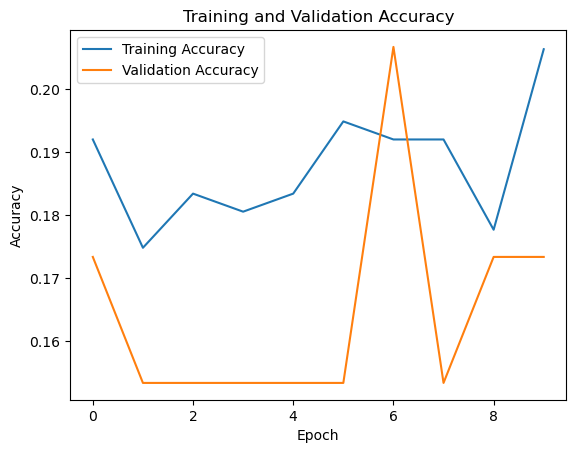

In [16]:
import matplotlib.pyplot as plt
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Set labels and title
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot

plt.show()

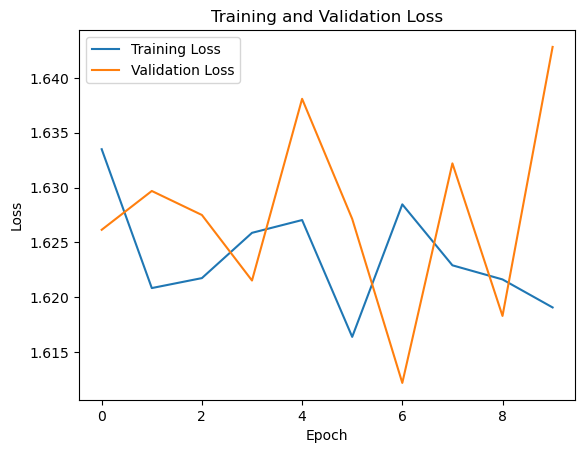

In [17]:
import matplotlib.pyplot as plt
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Set labels and title
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot

plt.show()